# Nén hình ảnh bằng thuật toán K-means Clustering và sử dụng thuật toán PCA để trực quan hóa kết quả

In [11]:
import os
import numpy as np
import re
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"
    
from scipy import optimize
from scipy.io import loadmat
import utils
%matplotlib inline

### 1 K-means Clustering

Trong bài toán này, ta sẽ thực hiện thuật toán K-mean và sử dụng nó để nén ảnh. Trước tiên, ta sẽ bắt đầu với một tập dữ liệu 2D  sẽ giúp ta có được trực giác về cách thuật toán K-mean hoạt động. Sau đó, sử dụng thuật toán K-mean để nén hình ảnh bằng cách giảm số lượng màu xuất hiện trong một hình ảnh xuống chỉ còn những màu phổ biến nhất trong hình ảnh đó.

**Implementing K-means**

Thuật toán K-mean là một phương pháp để tự động gom các ví dụ dữ liệu tương tự lại với nhau. Cụ thể, được cung cấp một tập huấn luyện $\{x^{(1)},\cdots, x ^ {(m)} \} $ (trong đó $x^{(i)}\in\mathbb{R}^n $) và muốn nhóm dữ liệu thành một số cụm cụm gắn kết. Trực giác đằng sau K-mean là một quy trình lặp lại bắt đầu bằng cách đoán các trọng tâm ban đầu, sau đó tinh chỉnh dự đoán này bằng cách liên tục gán các ví dụ cho các trọng tâm gần nhất của chúng và sau đó tính toán lại các trọng tâm dựa trên các result.

Thuật toán K-mean như sau:
    
    centroids = kMeansInitCentroids(X, K)
    for i in range(iterations):
        # Bước chỉ định cụm: Gán mỗi điểm dữ liệu cho trung tâm gần nhất. 
        # idx [i] tương ứng với cˆ(i), chỉ số của centroid được gán cho ví dụ i
        idx = findClosestCentroids(X, centroids)
        # Move centroid: Tính toán mean dựa trên các centroid
          centroids = computeMeans(X, idx, K)

**Tìm centroids gần nhất**

Trong giai đoạn gán cụm của thuật toán K-mean, thuật toán gán mọi ví dụ huấn luyện $ x ^ {(i)} $ cho trọng tâm gần nhất của nó, với các vị trí hiện tại của centroid. Cụ thể, với mọi ví dụ $ i $ chúng ta đặt

![](https://render.githubusercontent.com/render/math?math=c%5E%7B%28i%29%7D%20%3A%3D%20j%20%5Cquad%20%5Ctext%7Bthat%20minimizes%7D%20%5Cquad%20%5Clvert%5Crvert%20x%5E%7B%28i%29%7D%20-%20%5Cmu_j%20%20%5Clvert%5Crvert%5E2%2C&mode=display)

trong đó $ c ^ {(i)} $ là chỉ số của centroid gần nhất với $ x ^ {(i)} $ và $ \mu_j $ là vị trí (giá trị) của $ j ^ {th} $. Lưu ý rằng $ c ^ {(i)} $ tương ứng với idx [i].

Trong hàm findClosestCentroids, hàm này lấy ma trận dữ liệu X và vị trí của tất cả các centroid bên trong centroid và sẽ xuất ra một idx mảng một chiều chứa chỉ mục (a la một giá trị từ $\{1, ..., K\}$, trong đó K là tổng số centroid) của centroid gần nhất với mọi ví dụ đào tạo.

In [12]:
def findClosestCentroids(X, centroids):
    
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    for i in np.arange(idx.size):
        J = np.sqrt(np.sum(np.square(X[i] - centroids), axis = 1))
        idx[i] = np.argmin(J)
        
    return idx

**Tính centroid means**

Đưa ra các phép gán của mọi điểm cho một centroid, giai đoạn thứ hai của thuật toán tính toán lại, đối với mỗi centroid, giá trị trung bình của các điểm được gán cho nó. Cụ thể, với mỗi centroid $ k $ chúng ta đặt

![](https://render.githubusercontent.com/render/math?math=%5Cmu_k%20%3A%3D%20%5Cfrac%7B1%7D%7B%5Cleft%7C%20C_k%5Cright%7C%7D%20%5Csum_%7Bi%20%5Cin%20C_k%7D%20x%5E%7B%28i%29%7D&mode=display)

trong đó $ C_k $ là tập hợp các ví dụ được gán cho centroid $ k $. Cụ thể, nếu hai ví dụ nói $ x ^ {(3)} $ và $ x ^ {(5)} $ được gán cho centroid $ k = 2 $, thì ta nên cập nhật $\mu_2=\frac{1}{2}\left(x^{(3)}+x^{(5)}\right)$.

In [13]:
def computeCentroids(X, idx, K):
    
    m, n = X.shape
    centroids = np.zeros((K, n))
    for i in np.arange(K):
        centroids[i] = np.mean(X[idx == i], axis = 0)
        
    return centroids

**Khởi tạo ngẫu nhiên**

In [14]:
def kMeansInitCentroids(X, K):
   
    m, n = X.shape
    centroids = np.zeros((K, n))
    randidx = np.random.permutation(X.shape[0])
    # Take the first K examples as centroids
    centroids = X[randidx[:K], :]

    return centroids

### **2 Nén hình ảnh với K-means**

**K-means on pixels**

Giả sử ta sử dụng K = 16 màu hàng đầu để thể hiện hình ảnh, giờ đây ta có thể gán từng vị trí pixel cho trọng tâm gần nhất của nó bằng cách sử dụng hàm ```findClosestCentroids```. Điều này cho phép ta thể hiện hình ảnh gốc bằng cách sử dụng các phép gán centroid của từng pixel. Lưu ý rằng ta đã giảm đáng kể số lượng bit được yêu cầu để mô tả hình ảnh. Hình ảnh gốc yêu cầu 24 bit cho mỗi một trong số các vị trí 128 x 128 pixel, dẫn đến tổng kích thước là 128 x 128 x 24 = 393.216 bit. Biểu diễn mới yêu cầu một số lưu trữ trên dưới dạng dict gồm 16 màu, mỗi màu yêu cầu 24 bit, nhưng bản thân hình ảnh sau đó chỉ yêu cầu 4 bit cho mỗi vị trí pixel. Do đó, số bit cuối cùng được sử dụng là 16 x 24 + 128 x 128 x 4 = 65.920 bit, tương ứng với việc nén hình ảnh gốc khoảng 6 lần.

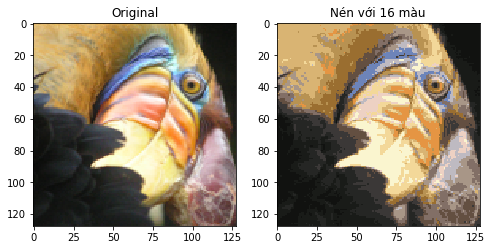

In [15]:
K = 16
max_iters = 10
A = mpl.image.imread('bird_small.png')
# Chia cho 255 để tất cả các giá trị nằm trong khoảng 0-1
A /= 255
X = A.reshape(-1, 3)
initial_centroids = kMeansInitCentroids(X, K)
# Run K-Means
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids,
                                 max_iters)

# Bây giờ chúng ta có thể khôi phục hình ảnh từ các chỉ số (idx) bằng cách ánh xạ từng pixel 
# (được chỉ định bởi chỉ mục của nó trong idx) vào giá trị centroid
# Định hình lại hình ảnh được phục hồi thành các kích thước phù hợp
X_recovered = centroids[idx, :].reshape(A.shape)

# Hiển thị hình ảnh gốc, chia tỷ lệ trở lại 255
fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Hiển thị hình ảnh đã nén, chia tỷ lệ trở lại 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Nén với %d màu' % K)
ax[1].grid(False)

Mặc dù hình ảnh thu được vẫn giữ được hầu hết các đặc điểm của bản gốc, chúng ta vẫn thấy thao tác nén.

# 2 Principal Component Analysis (PCA)

Trong bài tập này, bạn sẽ sử dụng phân tích thành phần chính (PCA) để thực hiện giảm kích thước. Trước tiên, bạn sẽ thử nghiệm một bộ dữ liệu 2D mẫu để có được trực giác về cách PCA hoạt động, sau đó sử dụng nó trên bộ dữ liệu lớn hơn gồm 5000 bộ dữ liệu hình ảnh khuôn mặt.

**Implementing PCA**

Trong phần này, ta sẽ thực hiện PCA. PCA bao gồm hai bước tính toán:

    1. Tính ma trận hiệp phương sai của dữ liệu.
    2. Sử dụng SVD (trong python, chúng ta sử dụng np.linalg.svd của numpy) để tính toán các hàm riêng U1,U2,...,Un. Chúng sẽ tương ứng với các thành phần chính của biến thể trong dữ liệu.
    
Trước tiên, tính ma trận hiệp phương sai của dữ liệu, được đưa ra bởi:
![](https://render.githubusercontent.com/render/math?math=%5CSigma%20%3D%20%5Cfrac%7B1%7D%7Bm%7D%20X%5ET%20X&mode=display)

trong đó $ X $ là ma trận dữ liệu với các ví dụ theo hàng và $ m $ là số lượng ví dụ. Lưu ý rằng $\Sigma $ là ma trận nxn và không phải là toán tử tổng.

Sau khi tính toán ma trận hiệp phương sai, ta có thể chạy SVD trên nó để tính toán các thành phần chính. Trong python và numpy (hoặc scipy), ta có thể chạy SVD bằng lệnh sau: U, S, V = np.linalg.svd (Sigma), trong đó U sẽ chứa các thành phần chính và S sẽ chứa ma trận đường chéo.

In [16]:
def pca(X):
   
    m, n = X.shape
    U = np.zeros(n)
    S = np.zeros(n)
    Sigma = (1 / m) * (X.T.dot(X))
    U, S, V = np.linalg.svd(Sigma)

    return U, S

In [17]:
def projectData(X, U, K):
   
    Z = np.zeros((X.shape[0], K))
    Z = np.dot(X,  U[:, :K])
    
    return Z

Sau khi chiếu dữ liệu lên không gian chiều thấp hơn, ta có thể khôi phục dữ liệu bằng cách chiếu chúng trở lại không gian chiều  ban đầu.

In [18]:
def recoverData(Z, U, K):
    
    X_rec = np.zeros((Z.shape[0], U.shape[0]))
    X_rec = Z.dot(U[:, :K].T)

    return X_rec

**PCA để trực quan hóa**

Trong bài tập nén hình ảnh K-mean trước đó, ta đã sử dụng thuật toán K-mean trong không gian RGB 3 chiều. Chúng ta đã giảm từng pixel của hình ảnh RGB để được đại diện bởi 16 cụm. Tiếp theo, ta hãy trực quan hóa các kết phân cụm trên trong không gian 3D . Mỗi điểm dữ liệu được tô màu theo cụm mà nó đã được gán.

<IPython.core.display.Javascript object>


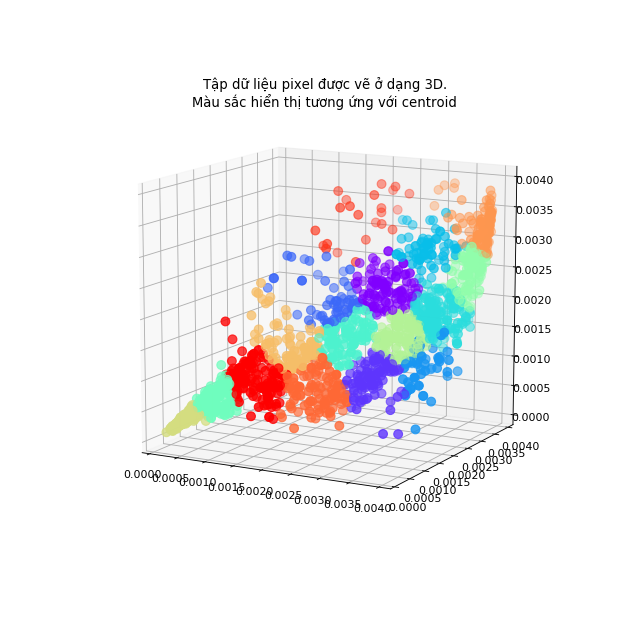

In [19]:
%matplotlib notebook
%matplotlib notebook
from matplotlib import pyplot

A = mpl.image.imread('bird_small.png')
A /= 255
X = A.reshape(-1, 3)

# thực hiện lại phân cụm K-mean
K = 16
max_iters = 10
initial_centroids = kMeansInitCentroids(X, K)
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids, max_iters)

#  Lấy mẫu 1000 chỉ mục ngẫu nhiên (vì làm việc với tất cả dữ liệu rất lâu. 
#  Nếu có một máy tính nhanh, ta có thể tăng điều này.
sel = np.random.choice(X.shape[0], size=2000)

fig = pyplot.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[sel, 0], X[sel, 1], X[sel, 2], cmap='rainbow', c=idx[sel], s=8**2)
ax.set_title('Tập dữ liệu pixel được vẽ ở dạng 3D.\nMàu sắc hiển thị tương ứng với centroid')
pass

Plot trên chỉ ra rằng trực quan hóa các bộ dữ liệu trong 3 chiều hoặc lớn hơn có thể là cồng kềnh. Do đó, thường chỉ mong muốn hiển thị dữ liệu ở dạng 2D ngay cả khi mất một số thông tin. Trong thực tế, PCA thường được sử dụng để giảm chiều của dữ liệu cho mục đích trực quan hóa.

Tiếp theo, ta sẽ áp dụng triển khai PCA  cho dữ liệu 3 chiều để giảm xuống còn 2 chiều và trực quan hóa kết quả trong một scatter pot 2D.

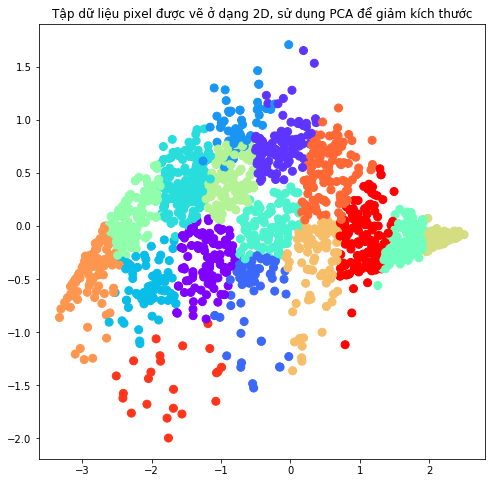

In [20]:
# chuẩn hóa X bằng cách trừ đi giá trị trung bình cho mỗi features
X_norm, mu, sigma = utils.featureNormalize(X)

# PCA và chiếu dữ liệu sang 2D
U, S = pca(X_norm)
Z = projectData(X_norm, U, 2)

%matplotlib inline

fig = pyplot.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.scatter(Z[sel, 0], Z[sel, 1], cmap='rainbow', c=idx[sel], s=64)
ax.set_title('Tập dữ liệu pixel được vẽ ở dạng 2D, sử dụng PCA để giảm kích thước')
ax.grid(False)
pass